# Experimental design (enhancing/relaxation of climatological wind field)

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import cosima_cookbook as cc
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/easterlies-collaborative/'
figdir = '/g/data/v45/akm157/figures/easterlies/paper_figures/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:42627 Dashboard: /proxy/8787/status,Cluster Workers: 7 Cores: 28 Memory: 125.21 GiB


Load datasets

In [2]:
session_ryf = cc.database.create_session()
experiment_ryf = '01deg_jra55v13_ryf9091'

ht = cc.querying.getvar(experiment_ryf, 'ht', session_ryf, n = 1).sel(yt_ocean = slice(None, -50))
ht = ht.interp(yt_ocean = np.flip(np.arange(-50.03, -90, -.1)))

iso = xr.open_dataset('/home/561/jn8053/g_e14/misc/Antarctic_isobath_1000m.nc')

In [3]:
u_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.u_10.1990_1991.nc'
u = xr.open_dataset(u_file, decode_times = False)['uas_10m'].mean('time')
v_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.v_10.1990_1991.nc'
v = xr.open_dataset(v_file, decode_times = False)['vas_10m'].mean('time')

wind_speed = np.sqrt(u**2 + v**2)

Zero divide line:

In [4]:
# mask peninsula to avoid anomalies there:
peninsula_mask = wind_speed.where(wind_speed.latitude<-68).where(wind_speed.longitude>285).where(wind_speed.longitude<296)*0
peninsula_mask = peninsula_mask.fillna(1)
peninsula_mask = peninsula_mask.where(peninsula_mask==1)

latitude = wind_speed.latitude
longitude = wind_speed.longitude

def find_min_lat(var):
    # mask outside of 60 and 80S:
    speed_mask = var.where(var.latitude<-60).where(var.latitude>-80)

    # first pass at latitude indices where speed is a minimum:
    min_lat_indices = (peninsula_mask*speed_mask).argmin(dim='latitude')

    # remove large latitude jumps in min_lat_indices:
    filtered_min_lat_indices = min_lat_indices.copy()
    for i in range(len(longitude)-1):
        if np.abs(min_lat_indices[i+1] - filtered_min_lat_indices[i]) > 4:
            filtered_min_lat_indices[i+1] = np.maximum(min_lat_indices[i+1],filtered_min_lat_indices[i])

    # and apply a smoothing:
    smoothed_min_lat_indices = np.ceil((filtered_min_lat_indices.roll(longitude=3,roll_coords=False) + \
                                    filtered_min_lat_indices.roll(longitude=2,roll_coords=False) + \
                                    filtered_min_lat_indices.roll(longitude=1,roll_coords=False) + \
                                    filtered_min_lat_indices.roll(longitude=-1,roll_coords=False) + \
                                    filtered_min_lat_indices.roll(longitude=-2,roll_coords=False) +
                                    filtered_min_lat_indices.roll(longitude=-3,roll_coords=False) + filtered_min_lat_indices)/7)

    # pick out latitude values:
    smoothed_min_lat = latitude.isel(latitude=smoothed_min_lat_indices.astype(int))
    
    return smoothed_min_lat

In [5]:
divide_line = find_min_lat(wind_speed)

Smooth the zero divide line and wrap it

In [6]:
divide_tail = divide_line.isel(longitude = slice(-5, None))
divide_tail['_lon_adj'] = divide_tail['longitude']-360
divide_tail = divide_tail.swap_dims({'longitude': '_lon_adj'})
divide_tail = divide_tail.sel(**{'_lon_adj': sorted(divide_tail._lon_adj)}).drop('longitude')
divide_tail = divide_tail.rename({'_lon_adj': 'longitude'})

divide_smoothed = xr.concat([divide_tail, divide_line], dim = 'longitude')
divide_smoothed = divide_smoothed.rolling(longitude = 5).mean('longitude').dropna('longitude')

In [10]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

def figure_1():
    fig = plt.figure(figsize = (30, 18))
    gr = gs.GridSpec(2, 2, figure = fig, wspace = -.05, hspace = 0.15); 
    axs = [fig.add_subplot(gr[:,0], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[0,1], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[1,1], projection = ccrs.SouthPolarStereo())]
    for ax, lb in zip(axs, ['a)', 'b)', 'c)']):
        ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'darkgrey', facecolor = 'darkgrey'))
        ax.spines['geo']
        ax.text(-0.03, .8, lb, transform=ax.transAxes, size = 24, weight='bold')
        ax.patch.set_alpha(0)
        ax.set_boundary(circle, transform = ax.transAxes)
    
    return fig, axs

Wrap lons to avoid white line

In [8]:
up, lon = add_cyclic_point(u, coord = longitude)
vp, lon = add_cyclic_point(v, coord = longitude)
ws, lon = add_cyclic_point(wind_speed, coord = longitude)

Patches for the additional nokatabatics experiment

In [12]:
poly1 = mpatches.Polygon(np.transpose(np.array([[161.5,170,170,161.5,161.5],[-79,-79,-72,-72,-79]])), closed = True, ec = 'darkgoldenrod', 
                        fill = True, lw = 1, fc = 'goldenrod', alpha = 0.4, transform=ccrs.PlateCarree(), zorder = 2)
poly2 = mpatches.Polygon(np.transpose(np.array([[58,73,73,58,58],[-69,-69,-67,-67,-69]])), closed = True, ec = 'darkgoldenrod', 
                        fill = True, lw = 1, fc = 'goldenrod', alpha = 0.4, transform=ccrs.PlateCarree(), zorder = 2)
poly3 = mpatches.Polygon(np.transpose(np.array([[138,148,148,138,138],[-69,-69,-66.2,-66.2,-69]])), closed = True, ec = 'darkgoldenrod', 
                        fill = True, lw = 1, fc = 'goldenrod', alpha = 0.4, transform=ccrs.PlateCarree(), zorder = 2)
poly4 = mpatches.Polygon(np.transpose(np.array([[297,305,305,320,320,305,305,297,297],[-70,-70,-75,-75,-79,-79,-77,-77,-70]])), closed = True, ec = 'darkgoldenrod', 
                        fill = True, lw = 1, fc = 'goldenrod', alpha = 0.4, transform=ccrs.PlateCarree(), zorder = 2)

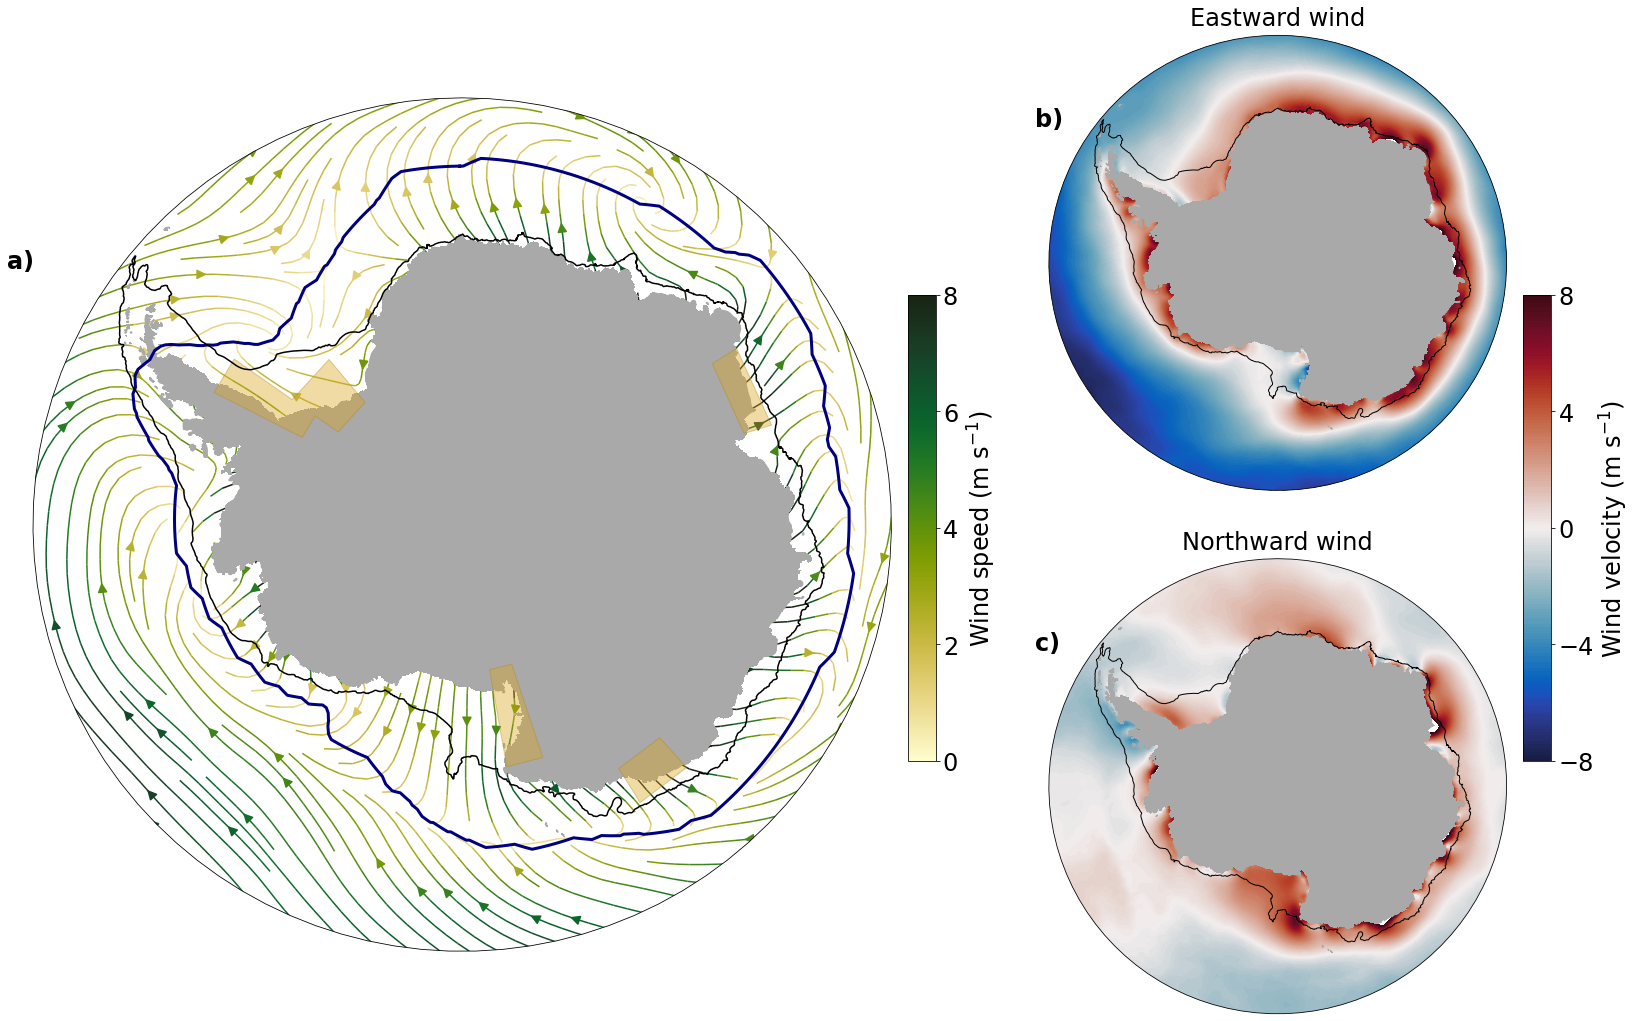

In [13]:
font_size = 24
plt.rcParams['font.size'] = 20
fig, axs = figure_1()
# Original wind field
c = axs[0].streamplot(lon, u['latitude'], up, vp, color = ws, norm = mcolors.Normalize(vmin = 0, vmax = 8, clip = True),
                      density = 2, arrowsize = 2, cmap = cmocean.cm.speed, transform = ccrs.PlateCarree(), zorder = 0)
axs[0].plot(divide_smoothed['longitude'], divide_smoothed, color = 'navy', linewidth = 3, transform = ccrs.PlateCarree())
axs[0].plot(iso['x'], iso['y'], color = 'k', linewidth = 1.5, transform = ccrs.PlateCarree())
axs[0].contourf(ht['xt_ocean'], ht['yt_ocean'], xr.where(np.isnan(ht), 1, np.nan), colors = ['darkgrey'], 
                transform = ccrs.PlateCarree())
cbar = fig.colorbar(c.lines, cax = fig.add_axes([0.53, 0.32, 0.013, 0.36]) , orientation = 'vertical')
cbar.set_ticks(np.arange(0, 10, 2))
cbar.set_label('Wind speed (m s$^{-1}$)',fontsize=font_size,labelpad=8)
cbar.ax.tick_params(labelsize=font_size)

# Masked regions
axs[0].add_patch(poly1)
axs[0].add_patch(poly2)
axs[0].add_patch(poly3)
axs[0].add_patch(poly4)

# UP perturbation
axs[1].contourf(lon, u['latitude'], -up, cmap = cmocean.cm.balance, levels = np.arange(-8, 8.1, .1), 
                extend = 'neither', transform = ccrs.PlateCarree())
axs[1].plot(iso['x'], iso['y'], color = 'k', linewidth = 1, transform = ccrs.PlateCarree())
axs[1].contourf(ht['xt_ocean'], ht['yt_ocean'], xr.where(np.isnan(ht), 1, np.nan), colors = ['darkgrey'], 
                transform = ccrs.PlateCarree())
axs[1].set_title('Eastward wind', pad=10)

# DOWN perturbation
c = axs[2].contourf(lon, v['latitude'], vp, cmap = cmocean.cm.balance, levels = np.arange(-8, 8.1, .1), 
                extend = 'neither', transform = ccrs.PlateCarree())
axs[2].plot(iso['x'], iso['y'], color = 'k', linewidth = 1, transform = ccrs.PlateCarree())
axs[2].contourf(ht['xt_ocean'], ht['yt_ocean'], xr.where(np.isnan(ht), 1, np.nan), colors = ['darkgrey'], 
                transform = ccrs.PlateCarree())
axs[2].set_title('Northward wind', pad=10)
cbar = fig.colorbar(c, cax = fig.add_axes([0.815, 0.32, 0.013, 0.36]) , orientation = 'vertical')
cbar.set_ticks(np.arange(-8, 10, 4))
cbar.set_label('Wind velocity (m s$^{-1}$)',fontsize=font_size,labelpad=4)
cbar.ax.tick_params(labelsize=font_size)

plt.savefig(figdir+'Figure1.png', bbox_inches = 'tight')